本次作业以垃圾邮件分类任务为基础，要求提取文本特征并使用朴素贝叶斯算法进行垃圾邮件识别（调用已有工具包或自行实现）。

### 任务介绍
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

本次实验

基本要求：
1. 提取正文部分的文本特征；
2. 划分训练集和测试集（可以借助工具包。一般笔记本就足够运行所有数据，认为实现困难或算力不够的同学可以采样一部分数据进行实验。）；
3. 使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9（本次实验可以使用已有的一些工具包完成如sklearn）；
4. 对比特征数目（词表大小）对模型效果的影响；
5. 提交代码和实验报告。

扩展要求：
1. 邮件头信息有时也可以协助判断垃圾邮件，欢迎学有余力的同学们尝试；
2. 尝试自行实现朴素贝叶斯算法细节；
3. 尝试对比不同的概率计算方法。

### 导入工具包

In [9]:
'''
提示：
若调用已有工具包，sklearn中提供了一些可能会用到的类。
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 提取文本特征向量的类
from sklearn.model_selection import train_test_split # 划分训练集和测试集
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 三种朴素贝叶斯算法，差别在于估计p(x|y)的方式
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import os
import numpy as np

### 实现辅助函数

In [10]:

def extract_body_from_email(filepath):
    """
    从一封邮件中提取正文部分
    """
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()

    # 统一换行符
    content = content.replace('\r\n', '\n')

    # 按空行分割
    parts = content.split('\n\n', 1)

    if len(parts) == 2:
        body = parts[1]
    else:
        # 如果没有明显分隔，直接返回全文（兜底）
        body = content

    return body.strip()

def load_all_bodies(data_dir):
    """
    读取目录下所有邮件正文
    返回：{filepath: body_text}
    """
    bodies = {}

    for root, _, files in os.walk(data_dir):
        for fname in files:
            filepath = os.path.join(root, fname)
            body = extract_body_from_email(filepath)
            bodies[filepath] = body

    return bodies

def load_dataset(label_file, base_dir):
    texts = []
    labels = []

    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            label, path = line.strip().split()
            filepath = os.path.join(base_dir, path.replace('../', ''))

            body = extract_body_from_email(filepath)

            texts.append(body)
            labels.append(1 if label == 'spam' else 0)

    return texts, labels


### 构造特征

In [11]:
# 特征构造： 将词变成模型能用的数值向量
texts, labels = load_dataset(
    label_file='trec06c-utf8/label/index',
    base_dir='trec06c-utf8'
)

#min_df=2 去掉只出现一次的噪声词
#max_df=0.95 去掉“的、了、是”这类全邮件通用词
vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    sublinear_tf=True  # 用 log(tf)
)

### 划分训练集和测试集

In [13]:
train_texts, test_texts, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,        # 20% 做测试集
    random_state=42,      # 固定随机种子，方便复现实验
    stratify=labels       # 保证 spam / ham 比例一致（非常重要）
)

X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)
# 检查划分结果
print(len(train_texts), len(test_texts))
print("Train spam ratio:", np.mean(y_train))
print("Test spam ratio:", np.mean(y_test))

51696 12924
Train spam ratio: 0.6631654286598576
Test spam ratio: 0.6631847725162489


### 训练朴素贝叶斯

In [14]:
# 训练朴素贝叶斯
# alpha=1.0 是为了防止：P(w∣y)=0，否则只要测试集中出现一个训练中没见过的词，整封邮件概率就变成0
clf = MultinomialNB(alpha=1.0)  # Laplace smoothing
clf.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### 输出准确率 / 混淆矩阵

In [15]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

Accuracy: 0.9646394305168678
[[3941  412]
 [  45 8526]]
              precision    recall  f1-score   support

         ham       0.99      0.91      0.95      4353
        spam       0.95      0.99      0.97      8571

    accuracy                           0.96     12924
   macro avg       0.97      0.95      0.96     12924
weighted avg       0.97      0.96      0.96     12924



### 加入邮件头信息

#### 修改辅助函数实现

In [16]:

# 同时返回 header + body
def extract_header_and_body(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()

    content = content.replace('\r\n', '\n')

    parts = content.split('\n\n', 1)

    if len(parts) == 2:
        header, body = parts
    else:
        header, body = content, ""

    return header.strip(), body.strip()

# 提取 Subject / From
def extract_header_fields(header):
    subject = ""
    sender = ""

    for line in header.split('\n'):
        if line.lower().startswith('subject:'):
            subject = line[len('subject:'):].strip()
        elif line.lower().startswith('from:'):
            sender = line[len('from:'):].strip()

    return subject, sender

# 把 header + body 拼在一起，但加标记防止混淆
def build_full_text(filepath):
    header, body = extract_header_and_body(filepath)
    subject, sender = extract_header_fields(header)
    # 加 SUBJECT / FROM / BODY，让模型区分字段语义
    full_text = (
        "SUBJECT " + subject + " "
        "FROM " + sender + " "
        "BODY " + body
    )

    return full_text

# 用这个文本重新构建数据集
def load_dataset_with_header(label_file, base_dir):
    texts = []
    labels = []

    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            label, path = line.strip().split()
            filepath = os.path.join(base_dir, path.replace('../', ''))

            text = build_full_text(filepath)

            texts.append(text)
            labels.append(1 if label == 'spam' else 0)

    return texts, labels


#### 构造特征，划分训练测试集，训练朴素贝叶斯（与前例完全一样）

In [18]:

# 特征构造： 将词变成模型能用的数值向量
texts, labels = load_dataset_with_header(
    label_file='trec06c-utf8/label/index',
    base_dir='trec06c-utf8'
)

#min_df=2 去掉只出现一次的噪声词
#max_df=0.95 去掉“的、了、是”这类全邮件通用词
vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    sublinear_tf=True  # 用 log(tf)
)

train_texts, test_texts, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,        # 20% 做测试集
    random_state=42,      # 固定随机种子，方便复现实验
    stratify=labels       # 保证 spam / ham 比例一致（非常重要）
)

X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)
# 检查划分结果
print(len(train_texts), len(test_texts))
print("Train spam ratio:", np.mean(y_train))
print("Test spam ratio:", np.mean(y_test))

# 训练朴素贝叶斯
# alpha=1.0 是为了防止：P(w∣y)=0，否则只要测试集中出现一个训练中没见过的词，整封邮件概率就变成0
clf = MultinomialNB(alpha=1.0)  # Laplace smoothing
clf.fit(X_train, y_train)

# 输出准确率 / 混淆矩阵
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

51696 12924
Train spam ratio: 0.6631654286598576
Test spam ratio: 0.6631847725162489
Accuracy: 0.9895543175487466
[[4268   85]
 [  50 8521]]
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      4353
        spam       0.99      0.99      0.99      8571

    accuracy                           0.99     12924
   macro avg       0.99      0.99      0.99     12924
weighted avg       0.99      0.99      0.99     12924



### 对比特征数目（词表大小）对模型效果的影响

在 sklearn 里，词表大小即特征数目，主要由这些参数控制：
- min_df：频词过滤（最重要）
- max_df：高频词过滤
- max_features：直接限制词表大小

要对比词表大小对模型效果的影响，我们需要固定模型和数据划分，只改变词表大小（max_features）。

max_features=  1000, vocab_size=  1000, acc=0.9643, f1=0.9729
max_features=  3000, vocab_size=  3000, acc=0.9755, f1=0.9813
max_features=  5000, vocab_size=  5000, acc=0.9776, f1=0.9829
max_features= 10000, vocab_size= 10000, acc=0.9805, f1=0.9851
max_features= 20000, vocab_size= 20000, acc=0.9806, f1=0.9852
max_features= 30000, vocab_size= 30000, acc=0.9833, f1=0.9873
max_features= 40000, vocab_size= 40000, acc=0.9838, f1=0.9877
max_features= 50000, vocab_size= 50000, acc=0.9837, f1=0.9876
max_features= 60000, vocab_size= 60000, acc=0.9843, f1=0.9881
max_features= 70000, vocab_size= 70000, acc=0.9835, f1=0.9875
max_features= 80000, vocab_size= 80000, acc=0.9838, f1=0.9877
max_features= 90000, vocab_size= 90000, acc=0.9843, f1=0.9881
max_features=100000, vocab_size=100000, acc=0.9845, f1=0.9883


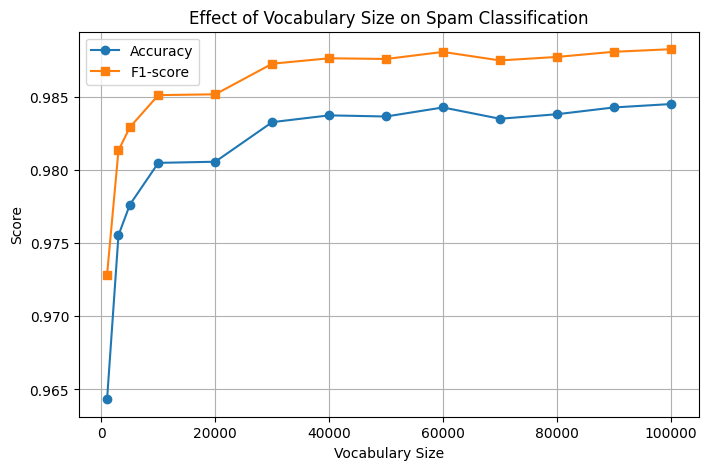

In [20]:
# 不同特征数量下的效果对比
from sklearn.metrics import f1_score

feature_sizes = [1000, 3000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
results = []

for max_feat in feature_sizes:
    vectorizer = TfidfVectorizer(
        max_features=max_feat,
        min_df=2,
        max_df=0.95
    )

    X_train = vectorizer.fit_transform(train_texts)
    X_test  = vectorizer.transform(test_texts)

    clf = MultinomialNB(alpha=1.0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    results.append((max_feat, X_train.shape[1], acc, f1))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

vocab_sizes = []
accuracies = []
f1_scores = []

for r in results:
    print(f"max_features={r[0]:6d}, "
          f"vocab_size={r[1]:6d}, "
          f"acc={r[2]:.4f}, "
          f"f1={r[3]:.4f}")
    vocab_sizes.append(r[1])
    accuracies.append(r[2])
    f1_scores.append(r[3])

# 画 Accuracy 和 F1-score
plt.plot(vocab_sizes, accuracies, marker='o', label='Accuracy')
plt.plot(vocab_sizes, f1_scores, marker='s', label='F1-score')

plt.xlabel('Vocabulary Size')
plt.ylabel('Score')
plt.title('Effect of Vocabulary Size on Spam Classification')
plt.legend()
plt.grid(True)
plt.show()

(需要运行几十秒，会输出图表)

In [ ]:
词表数从40000开始似乎就没有更明显的提高。